In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance

# Prepare the Data

In [2]:
dataset = pd.read_csv('../adult_with_col_names.csv')

# Remove the "education-num" and "fnlwgt" columns since they do not add
# any useful information to the algorithm.
dataset.drop(['education-num', 'fnlwgt'], axis=1, inplace=True)

# Clean up categorical, string-valued attributes
def clean_value(x):
    val = x.strip().lower()
    val = "unknown" if val == "?" else val
    return val

for column in ['workclass', 'education', 'relationship', 'marital-status', 'occupation', 'race', 'sex', 'native-country', 'income']:
    dataset[column] = dataset[column].map(clean_value)

# Convert the output label from categorical to numerical
dataset['income'] = dataset.income.map(lambda x: 1 if x == ">50k" else 0) 

# Print the first 10 items in the dataset
dataset.head(10)

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,state-gov,bachelors,never-married,adm-clerical,not-in-family,white,male,2174,0,40,united-states,0
1,50,self-emp-not-inc,bachelors,married-civ-spouse,exec-managerial,husband,white,male,0,0,13,united-states,0
2,38,private,hs-grad,divorced,handlers-cleaners,not-in-family,white,male,0,0,40,united-states,0
3,53,private,11th,married-civ-spouse,handlers-cleaners,husband,black,male,0,0,40,united-states,0
4,28,private,bachelors,married-civ-spouse,prof-specialty,wife,black,female,0,0,40,cuba,0
5,37,private,masters,married-civ-spouse,exec-managerial,wife,white,female,0,0,40,united-states,0
6,49,private,9th,married-spouse-absent,other-service,not-in-family,black,female,0,0,16,jamaica,0
7,52,self-emp-not-inc,hs-grad,married-civ-spouse,exec-managerial,husband,white,male,0,0,45,united-states,1
8,31,private,masters,never-married,prof-specialty,not-in-family,white,female,14084,0,50,united-states,1
9,42,private,bachelors,married-civ-spouse,exec-managerial,husband,white,male,5178,0,40,united-states,1


## Convert categorical, text-based attributes into numeric attributes (One-Hot Encoding)

In [3]:
dataset = pd.get_dummies(dataset, columns=[
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country',
])

dataset

,age,capital-gain,capital-loss,hours-per-week,income,workclass_federal-gov,workclass_local-gov,workclass_never-worked,workclass_private,workclass_self-emp-inc,...,native-country_puerto-rico,native-country_scotland,native-country_south,native-country_taiwan,native-country_thailand,native-country_trinadad&tobago,native-country_united-states,native-country_unknown,native-country_vietnam,native-country_yugoslavia
0,39,2174,0,40,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50,0,0,13,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,0,0,40,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,53,0,0,40,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,28,0,0,40,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,0,0,38,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
32557,40,0,0,40,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
32558,58,0,0,40,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
32559,22,0,0,20,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


## Divide the Data into Inputs and Outputs and Resample with SMOTE

### Separate the dataset into inputs(X) and outputs(y)

In [4]:
X = dataset.drop('income', axis=1).values
y = dataset['income'].values

print(f'Input(X) shape: {np.shape(X)}')
print(f'Output(y) shape: {np.shape(y)}')

Input(X) shape: (32561, 106)
Output(y) shape: (32561,)


### Why do we need SMOTE?
As seen in the histogram below, items labeled as ">50k" (x=1) appear significantly less frequently than items labeled as "<=50k" (x=0). This demonstrates an imbalance in our dataset, which can lead the model to be biased towards incorrectly labeling new individuals as making more than $50k a year. To overcome this problem, we use a Synthetic Minority Oversampling Technique (SMOTE), which will increase the minority class by creating sythetic points that are similar to other points in that class.

<AxesSubplot:>

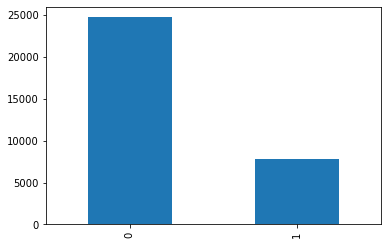

In [5]:
dataset["income"].value_counts().plot.bar()

### Balanced resample of the data

Increase the minority class by creating synthetic points that are similar to 256 other points in the minority class.

In [6]:
oversample = SMOTE(sampling_strategy='not majority', k_neighbors=256)
X, y = oversample.fit_resample(X, y)

print(f'Input(X) shape: {np.shape(X)}')
print(f'Output(y) shape: {np.shape(y)}')

Input(X) shape: (49440, 106)
Output(y) shape: (49440,)


<AxesSubplot:>

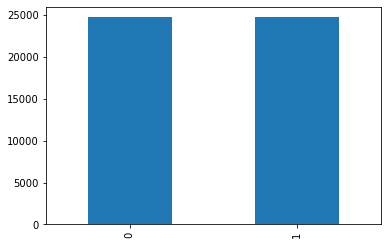

In [7]:
pd.DataFrame(y, columns=["income"])["income"].value_counts().plot.bar()

### Create Training and Testing Sets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=24)
print("Number of training samples:", len(X_train))
print("Number of testing samples:", len(X_test))

Number of training samples: 42024
Number of testing samples: 7416


# Base Model

I did not use PyCaret to find the parameters for this model. Instead, I followed this guide for implementing Random Search Training (basically what PyCaret does, except by hand) https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

## Creating the Model

In [9]:
model = RandomForestClassifier(
    bootstrap=False,
    max_depth=44,
    max_features="sqrt",
    min_samples_leaf=2,
    min_samples_split=12,
    n_estimators=112,
    random_state=0,
    criterion="entropy"
)

model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=44,
                       max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=12, n_estimators=112, random_state=0)

## Evaluating the Model

### Accuracy Score

In [10]:
model.score(X_test, y_test)

0.9095199568500539

### Crosvalidation

In [11]:
cv_scores = cross_val_score(model, X, y, cv=10)
print("Scores:", cv_scores)

Scores: [0.77487864 0.78964401 0.79389159 0.92495955 0.95145631 0.95024272
 0.95651294 0.95570388 0.95489482 0.94822006]


0.9000 accuracy with a standard deviation of 0.0752


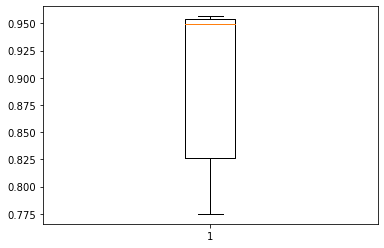

In [12]:
print("%0.4f accuracy with a standard deviation of %0.4f" % (cv_scores.mean(), cv_scores.std()))

cv_figure = plt.figure()
plt.boxplot(cv_scores)
plt.show()

### Confusion Matrix

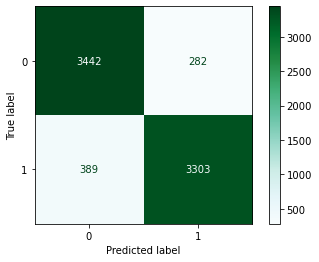

In [13]:
cm = confusion_matrix(y_test, model.predict(X_test))
ConfusionMatrixDisplay(cm, display_labels=["0", "1"]).plot(cmap='BuGn')

## Feature Visualization

### Feature Importance

In [14]:
importances = model.feature_importances_
feature_importances = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

### Feature Importance Based on Mean Decrease in Impurity

Gini Importance or Mean Decrease in Impurity (MDI) calculates each feature importance as the sum over the number of splits (across all tress) that include the feature, proportionally to the number of samples it splits.

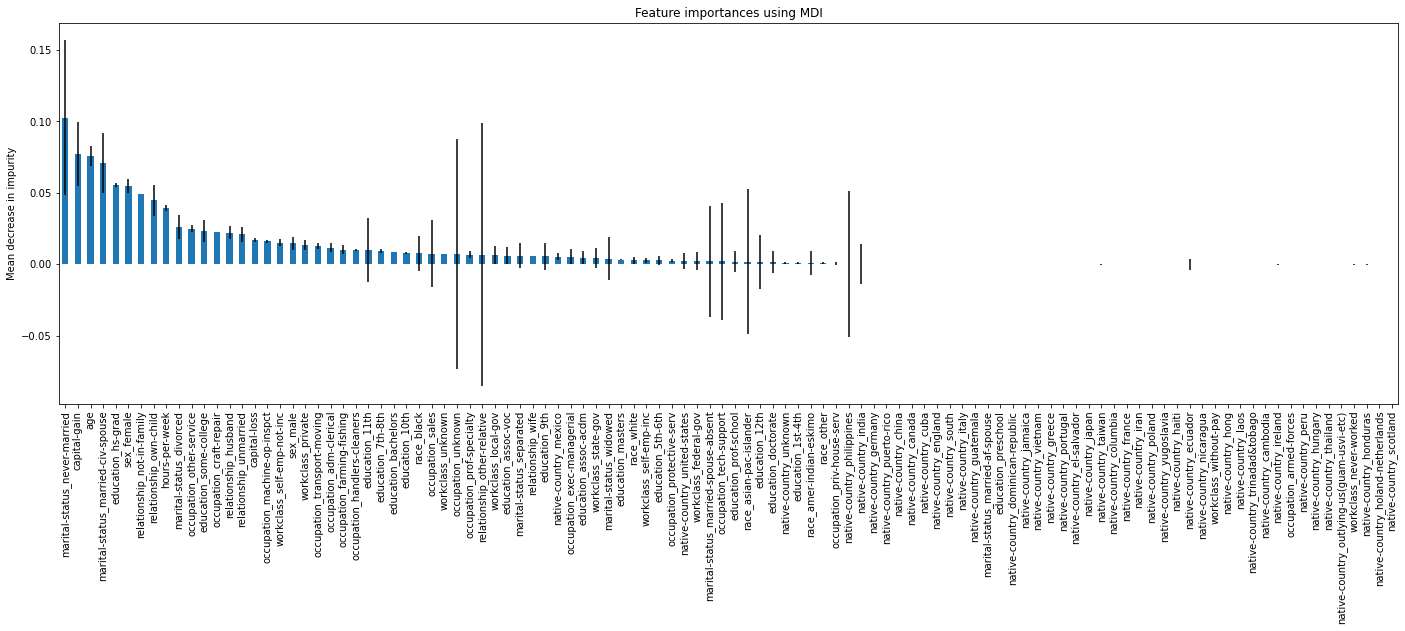

In [15]:
forest_importances = pd.Series(importances, index=dataset.drop("income", axis=1).columns)
forest_importances.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=feature_importances, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

fig.set_size_inches(24, 7)

### Feature Importance Based on Feature Permutation

The Mean Decrease Accuracy plot expresses how much accuracy the model losses by excluding each variable. The more the accuracy suffers, the more important the variable is for the successful classification. 

For models with high-cardinality features, it is recommended to analayze the feature importances based on permutations on the full model. That way, importances are not biased towards those high-cardinality features.

After transforming our dataset using a one-hot encoding, all attributes that were once high in cardinality were reduced to a cadinality of 2, so this approach does not apply to us as much. However, as seen below, using permutations on the feature importance analysis decreases the variance in the Mean Accuracy Decrease for each feature, and even shows some features as having negative importance.

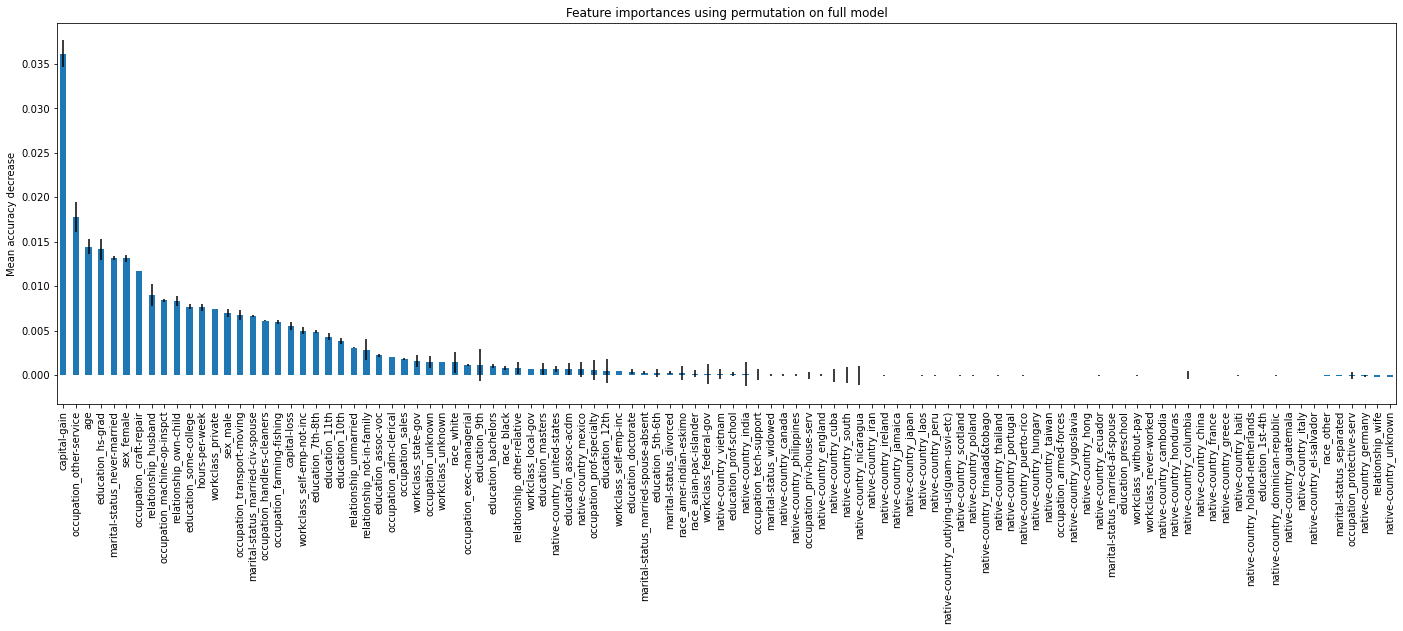

In [16]:
result = permutation_importance(model, X_test, y_test, n_repeats=20, random_state=24, n_jobs=-1)
forest_importances = pd.Series(result.importances_mean, index=dataset.drop("income", axis=1).columns)
forest_importances.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax, )

ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")

fig.set_size_inches(24, 7)

From the above results, we can see that many features have an importance of less than or equal to 0. This means that we can remove those features in the final model without any cost on the performance. Moreover, removing those features with negative importance in the permutation analysis may even increase the accuracy of the model.

**Should we show the cumulative or average importance of each "super feature"? E.g., the cumulative importance of all features derived from the original "education" feature.**

## Next Steps (Path Visualization)

- Showing the full structure of one of the trees will not provide a good visualization.
    - The trees are too deep.
    - For the current model with 91% accuracy, we must create trees with a max depth of 44... That's 2^44 leaf nodes!
    - Showing that on a computer screen will make for a very confusing and irresponsive visualization.
- Instead, we can display how each of the features contributed to the final decision.
    - For example, what is the decision path taken by a single tree, independently of all other paths?
        - **Do we select the tree randomly or use model.base_stimator?**
        - See below for an example.
    - Show a plot of the probability determined by the model for each class.
        - Easy to do: `model.predict_proba(X)`
    - **What else can we show?**
    - **What are other dynamic properties of the model that can be visualized (that depend on the input of an individual)?**

### Decision Path Taken by the Base Stimator to Make a Prediction on Individual #213 from the Test Set.

This in an extension of the code found here: https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#decision-path

PS: This is what we would have used to highlight the decision path on a tree visualization.

In [17]:
estimator = model.base_estimator.fit(X_test, y_test)
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold

node_indicator = estimator.decision_path(X_test)
leaf_id = estimator.apply(X_test)

sample_id = 213

# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]

print(f"Feature values for sample {sample_id}:", X_test[sample_id], "\n")
print(f"== Rules used to predict sample {sample_id}:")

features_used = []

for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue

    # check if value of the split feature for sample 0 is below threshold
    if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"
        
    if feature[node_id] not in features_used:
        features_used.append(feature[node_id])

    print(
        "decision node #{node} : (X_test[{sample}, {feature}({feature_name})] = {value}) "
        "{inequality} {threshold})".format(
            node=node_id,
            sample=sample_id,
            feature=feature[node_id],
            feature_name=dataset.columns[feature[node_id]],
            value=X_test[sample_id, feature[node_id]],
            inequality=threshold_sign,
            threshold=threshold[node_id],
        )
    )

Feature values for sample 213: [52  0  0 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
  0  0  0  1  0  0  0  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  1  0  0  0] 

== Rules used to predict sample 213:
decision node #0 : (X_test[213, 33(marital-status_married-spouse-absent)] = 0) <= 0.5)
decision node #1 : (X_test[213, 29(education_some-college)] = 0) <= 0.5)
decision node #2 : (X_test[213, 24(education_doctorate)] = 0) <= 0.5)
decision node #3 : (X_test[213, 28(education_prof-school)] = 0) <= 0.5)
decision node #4 : (X_test[213, 18(education_5th-6th)] = 0) <= 0.5)
decision node #5 : (X_test[213, 62(race_white)] = 0) <= 0.5)
decision node #6 : (X_test[213, 38(occupation_armed-forces)] = 0) <= 0.5)
decision node #7 : (X_test[213, 89(native-country_laos)] = 0) <= 0.5)
decision node #8 : (X_test[213,

In [58]:
attributes = [
    'age',
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country',
    'capital-gain',
    'capital-loss',
    'hours-per-week'
]

collected_importances = {
    # "feature_name": [importance_val1, importance_val2, ...]
}

for feature, importance in forest_importances.items():
    found = False
    
    # Find which attribute the feature belongs to 
    for base in attributes:
        if feature.startswith(base):
            found = True
            
            # If the attribute is already in the dict,
            # append the value to the dict entry
            if base in collected_importances:
                collected_importances[base].append(importance)
            else:
                collected_importances[base] = [importance]
            break
        
    if not found:
        print(f"Feature '{feature}' does not have a base.")
        

avg_importance = { attr: sum(vals) / len(vals) for attr, vals in collected_importances.items()  }

pprint(avg_importance)

{'age': 0.014468716289104627,
 'capital-gain': 0.03612459546925566,
 'capital-loss': 0.005501618122977336,
 'education': 0.0026332423139158556,
 'hours-per-week': 0.007632146709816617,
 'marital-status': 0.0029097318539066034,
 'native-country': 3.066086197154224e-05,
 'occupation': 0.004268698309960442,
 'race': 0.0005312837108953539,
 'relationship': 0.003976761956130892,
 'sex': 0.010079557713052863,
 'workclass': 0.0018705801270526177}


In [43]:
import altair as alt

In [56]:
alt.Chart(pd.DataFrame({
    "attributes": avg_importance.keys(),
    "importances": avg_importance.values(),
})).mark_bar().encode(
    x="attributes:N",
    y="importances:Q",
).properties(
    width=300,
    height=200
)

alt.Chart(...)